# Librerías

In [1]:
import pandas as pd
from palette_creator import PaletteCreator, show_palette
from pathlib import Path
import cv2
import json

# Funciones auxiliares

In [2]:
class DataLoader:
    def __init__(self, file_list, batch_size):
        self.batch_size = batch_size
        self.file_list = file_list
        self.num_samples = len(self.file_list)
        self.num_batches = (self.num_samples + batch_size - 1) // batch_size
        self.current_batch = 0

    def __iter__(self):
        return self
    
    def load_img(self, path_img):
        path_img = str(path_img)

        # Check if path exists
        if not Path(path_img).exists():
            print(f"Path {path_img} doesn't exist")
            return None
        
        return cv2.cvtColor(cv2.imread(path_img), cv2.COLOR_BGR2RGB)
    
    def __len__(self):
        return self.num_samples

    def __next__(self):
        if self.current_batch < self.num_batches:
            batch_start = self.current_batch * self.batch_size
            batch_end = (self.current_batch + 1) * self.batch_size
            batch_files = self.file_list[batch_start:batch_end]

            batch_images = [self.load_img(file) for file in batch_files]

            self.current_batch += 1
            return batch_images
        else:
            self.current_batch = 0
            raise StopIteration
        
    def __item__(self, index):
        if isinstance(index, slice):
            return [self.load_img(file) for file in self.file_list[index]]
        return self.load_img(self.file_list[index])
    
    def __getitem__(self, index):
        return self.__item__(index)

In [3]:
import numpy as np

class NumpyEncoder(json.JSONEncoder):
    """ Special json encoder for numpy types """
    def default(self, obj):
        if isinstance(obj, (np.int_, np.intc, np.intp, np.int8,
                            np.int16, np.int32, np.int64, np.uint8,
                            np.uint16, np.uint32, np.uint64)):
            return int(obj)
        elif isinstance(obj, (np.float_, np.float16, np.float32,
                              np.float64)):
            return float(obj)
        elif isinstance(obj, (np.ndarray,)):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

def save_results_to_db(db, method, results): 
    palettes, proportions = results
    db[f"{method}_palette"], db[f"{method}_proportions"] = palettes, proportions
    db[f"{method}_palette"] = db[f"{method}_palette"].apply(lambda x: json.dumps(x, cls=NumpyEncoder))
    db[f"{method}_proportions"] = db[f"{method}_proportions"].apply(lambda x: json.dumps(x, cls=NumpyEncoder))

# Configuración

In [4]:
# establecer rutas
PATH_IMAGES_FOLDER = Path('data/beatriz_gonzalez')
PATH_IMAGES_METADATA = Path("beatriz_gonzalez.csv")

db = pd.read_csv(PATH_IMAGES_METADATA)
db["path_image"] = PATH_IMAGES_FOLDER/db["filename"]

# Preprocesamiento
Cargar imagenes y aplicarles filtros de ser necesario

In [5]:
%%time
images = DataLoader(db["path_image"][:50], 5) # cargar imagenes en una lista

CPU times: user 34 µs, sys: 60 µs, total: 94 µs
Wall time: 97 µs


In [6]:
print(f'Total de imagenes: {len(images)}')

Total de imagenes: 50


Filtros de preprocesamiento a aplicar

In [7]:
# Rezise image if it is too big
def resize(img):
    while img.size > 40000:
        img = cv2.resize(img, None, fx = 0.75, fy = 0.75)
    return img

pre_process = resize

(-0.5, 2243.5, 1653.5, -0.5)

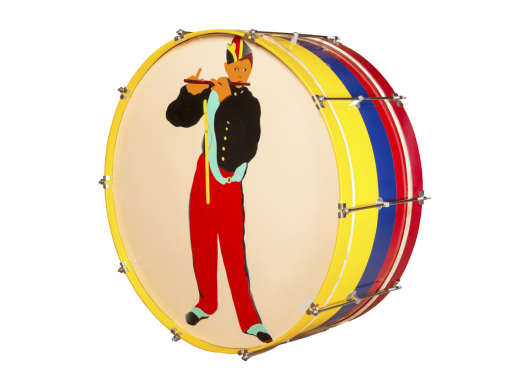

In [8]:
import matplotlib.pyplot as plt
plt.imshow(images[18])
plt.axis('off')

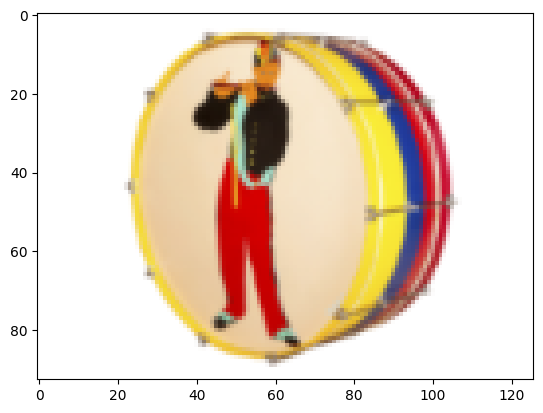

In [9]:
# aplicar filtros que homogenicen las imágenes
test = pre_process(images[18])
plt.imshow(test)
# plt.axis('off')

# Procesamiento PNN

In [10]:
pc = PaletteCreator(method="pnn", optimize_palette=True)

In [11]:
import concurrent.futures
import multiprocessing

def process_batch(batch):
    batch_preprocessed = [pre_process(img) for img in batch]
    palette, proportions = pc.create_palette(batch_preprocessed)
    return palette, proportions, batch

def process_images(images):
    results = [[], [], []]

    # Number of processes to use (adjust as needed)
    num_processes = multiprocessing.cpu_count()

    with concurrent.futures.ProcessPoolExecutor(max_workers=num_processes) as executor:
        # Use executor.map to parallelize the processing of batches
        futures = {executor.submit(process_batch, batch): batch for batch in images}

        # Collect results as they become available
        for future in concurrent.futures.as_completed(futures):
            try:
                palette, proportions, batch_imgs = future.result()
                results[0].extend(palette)
                results[1].extend(proportions)
                results[2].extend(batch_imgs)
            except Exception as e:
                # Handle exceptions if any
                print(f"Error processing batch: {e}")

    return results

# Assuming `images` is a list of batches
results = process_images(images)

100%|██████████| 5/5 [00:34<00:00,  6.87s/it]


In [12]:
len(results[0]), len(results[1]), len(results[2])

(50, 50, 50)

## Guardar resultados

In [13]:
# save_results_to_db(db, f'{pc.method}+average_filter', results)
# db.head()

In [66]:
# db.to_csv(PATH_IMAGES_METADATA, index=False)

# Ejemplo de mapeo de la imagen (Segmentos con su respectivo color representante)

# Ejemplo de visualización

In [15]:
# db = pd.read_csv(PATH_IMAGES_METADATA)

In [13]:
# palette_img = db[f'{pc.method}+average_filter_palette'].values
# proportions_img = db[f'{pc.method}+average_filter_proportions'].values
palette_img = results[0]
proportions_img = results[1]
imgs = results[2]

In [71]:
class PairCombinations:
    """Create an iterator that returns all possible combinations of pairs of elements from a list within a range of distance."""

    def __init__(self, lst, distance):
        self.lst = list(range(len(lst)))
        self.distance = distance
        self.curr_id = 0
        self.second_id = 1
    
    def __iter__(self):
        return self
    
    def __next__(self):
        if self.curr_id >= len(self.lst):
            raise StopIteration
        
        if self.second_id >= len(self.lst):
            self.curr_id += 1
            self.second_id = self.curr_id + 1
            return self.__next__()
        
        # Check if the distance between the two elements is within the range
        if self.second_id - self.curr_id <= self.distance:
            # If so, return the pair and increment the second id
            pair = (self.curr_id, self.second_id)
            self.second_id += 1
            return pair
        else:
            # Otherwise, increment the current_id and reset the second_id
            self.curr_id += 1
            self.second_id = self.curr_id + 1
            return self.__next__()
        
class PNN:
    def __init__(self, num_clusters, max_iterations=100, initial_clusters=100):
        self.num_clusters = num_clusters
        self.clusters = []
        self.max_iterations = max_iterations
        self.initial_clusters = initial_clusters

    def initialize_clusters(self, image):
        # Create 100 uniformly distributed clusters
        # ordered_pixels = sorted(image, key=lambda x: np.mean(x))
        # self.clusters = np.array_split(ordered_pixels, self.initial_clusters)
        max = (image).max(axis=0)
        min = (image).min(axis=0)
        centroids = np.linspace(min, max, self.initial_clusters)
        self.clusters = [[] for _ in centroids]
        for i in range(len(image)):
            self.clusters[np.argmin(np.linalg.norm(image[i] - centroids, axis=1))].append(image[i])
        self.clusters = [np.array(cluster) for cluster in self.clusters if len(cluster) > 0]

    def find_best_combination(self, clusters):
        combs = []
        impact = []

        combinations = PairCombinations(clusters, 10)
        for combo in combinations:
            c1_id, c2_id = combo

            # Original formula of distance between clusters
            cluster_centroids = [np.mean(clusters[c1_id], axis=0), np.mean(clusters[c2_id], axis=0)]
            distance = np.linalg.norm(cluster_centroids[0] - cluster_centroids[1])

            # Find the impact on the mse of merging these two clusters
            mse_impact = distance ** 2 * (len(clusters[c1_id]) * len(clusters[c2_id])) / (len(clusters[c1_id]) + len(clusters[c2_id])) # Original formula
            # mse_impact = distance ** 2 # Do not take into account the number of pixels in the clusters

            combs.append((c1_id, c2_id))
            impact.append(mse_impact)
        
        # Find the combination with the lowest impact
        return combs[np.argmin(impact)]

    def merge_clusters(self, c1_id, c2_id):
        cluster1 = self.clusters[c1_id]
        cluster2 = self.clusters[c2_id]
        new_cluster = np.concatenate((cluster1, cluster2))
        # remove the old clusters
        try:
            del self.clusters[c2_id]
            del self.clusters[c1_id]
        except Exception as e:
            print('Ids to merge', c1_id, c2_id, len(self.clusters))
            raise e
        # add the new cluster
        self.clusters.insert(c1_id, new_cluster)
        # Sort the clusters by their mean
        self.clusters = sorted(self.clusters, key=lambda x: np.mean(x))


    def fit(self, img):
        self.img_size = len(img)
        self.initialize_clusters(img)

        for _ in range(self.max_iterations):
            if len(self.clusters) > self.num_clusters:
                clusters_to_merge = self.find_best_combination(self.clusters)
                self.merge_clusters(*clusters_to_merge)
            else:
                break

    def get_palette(self):
        # palette_img = [np.median(cluster, axis=0) for cluster in self.clusters]
        # palette_img = [np.mean(cluster, axis=0) for cluster in self.clusters]
        palette_img = []
        stds = []
        for cluster in self.clusters:
            pixels, counts= np.unique(cluster, axis=0, return_counts=True)
            palette_img.append(pixels[np.argmax(counts)])
            stds.append(np.std(cluster))
        proportions_img = [len(cluster) / self.img_size for cluster in self.clusters]
        palette_img = np.array(palette_img)
        proportions_img = np.array(proportions_img)
        variance = np.std(palette_img)

        # Sort the colors and proportions by proportions
        palette_img, proportions_img, clusters = zip(
            *sorted(zip(palette_img, proportions_img, self.clusters), key=lambda x: x[1], reverse=True)
        )
        # palette_img, proportions_img, stds = zip(
        #     *sorted(zip(palette_img, proportions_img, stds), key=lambda x: x[-1])
        # )
        # return palette_img[:-2], proportions_img[:-2]
        return palette_img, proportions_img, clusters

In [115]:
pnn_model = PNN(8, max_iterations=500, initial_clusters=350)
pnn_model.fit(test.reshape(-1, 3))

palette, proportions, clusters = pnn_model.get_palette()

In [139]:
import numpy as np

def optimize_palette(palette, proportions):
    palette_ = np.array(palette).astype(int)
    new_palette = []
    remaining = []
    remaining_props = []
    new_proportions = []

    # Calculate pairwise distances using vectorized operations
    distances = np.linalg.norm(palette_[:, np.newaxis, :] - palette_[np.newaxis, :, :], axis=2)

    # Find nearest neighbors
    NN = np.partition(distances, 1, axis=1)[:, 1]

    i = 0
    r = 0

    # Sort indices of NN in descending order
    NN_sorted = np.argsort(NN)[::-1]

    while len(new_palette) < 6:
        if i >= len(NN_sorted):
            new_palette.append(remaining[r])
            new_proportions.append(remaining_props[r])
            r += 1
            continue

        NN_distance = NN[NN_sorted[i]]
        neighbors_mask = NN == NN_distance

        # Use boolean indexing to get proportions and palette elements for the neighbors
        props = np.array(proportions)[neighbors_mask]
        biggest = np.max(props)

        # Use boolean indexing to get the corresponding palette elements
        biggest_palette_element = palette_[np.array(proportions) == biggest][0]

        # Add neighbors with different proportions to remaining
        remaining.extend(palette_[np.in1d(np.array(proportions), props[props != biggest])])
        remaining_props.extend(props[props != biggest])

        new_palette.append(biggest_palette_element)
        new_proportions.append(biggest)
        i += np.sum(neighbors_mask)

    return new_palette, new_proportions

# Example usage
optimized_palette, new_proportions = optimize_palette(palette, proportions)
print(new_proportions)

[0.028588496330431815, 0.06955111793821471, 0.08337600273084143, 0.5186891961085509, 0.12493599590373784, 0.020993343573988736]


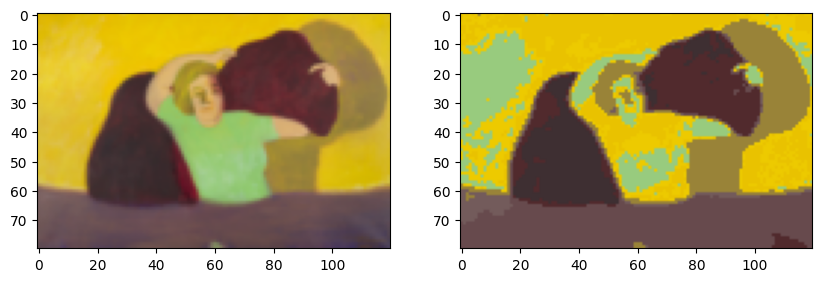

In [79]:
img_reshape = test.reshape(-1, 3)
mapped_img = np.copy(img_reshape).astype(int)
for cluster in pnn_model.clusters:
    # mapped_color = np.mean(cluster, axis=0).astype(int)
    pixels, counts= np.unique(cluster, axis=0, return_counts=True)
    mapped_color = pixels[np.argmax(counts)]
    for c_pixel in cluster:
        condition = np.all(mapped_img == c_pixel, axis=1)
        mapped_img[condition] = mapped_color

plt.subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(test)
ax2.imshow(mapped_img.reshape(test.shape))

(993, 1200, 3)


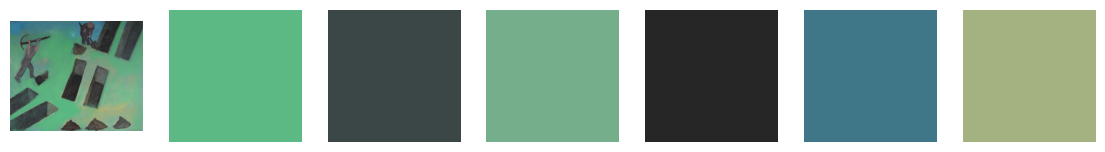

(218, 76, 3)


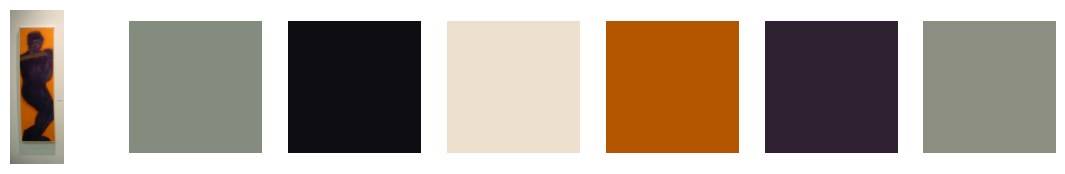

(835, 2908, 3)


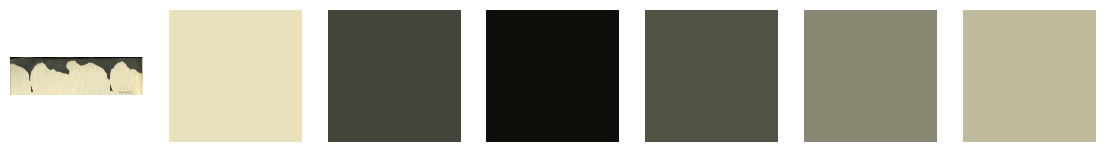

(3613, 1596, 3)


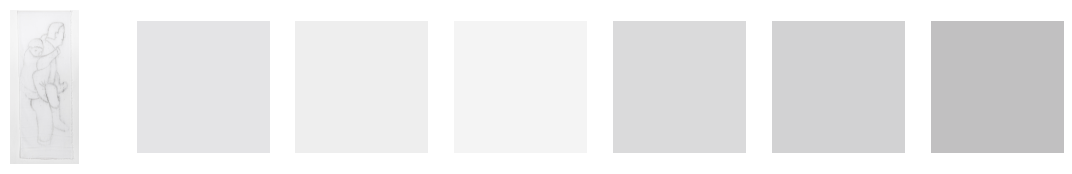

(3548, 3891, 3)


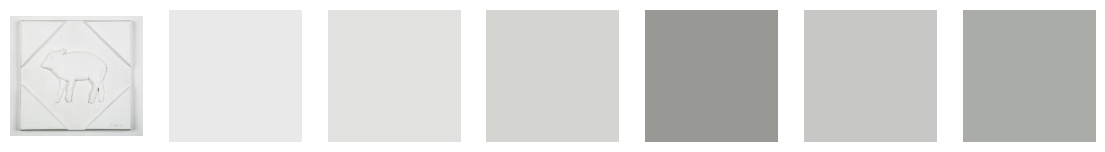

(1073, 1200, 3)


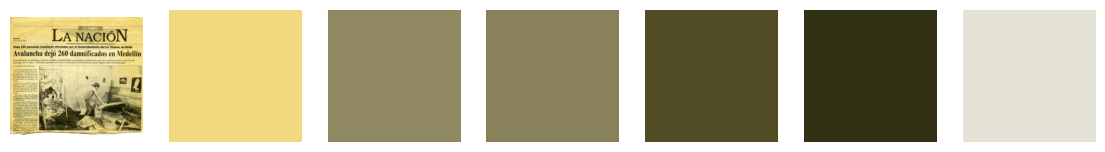

(531, 1200, 3)


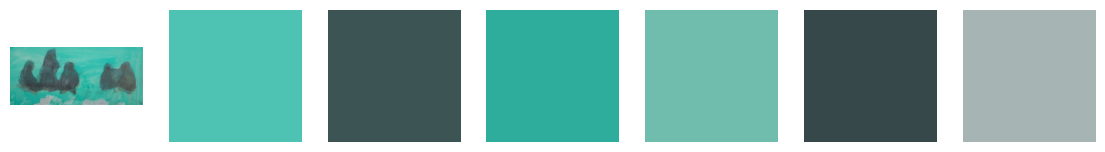

(476, 1200, 3)


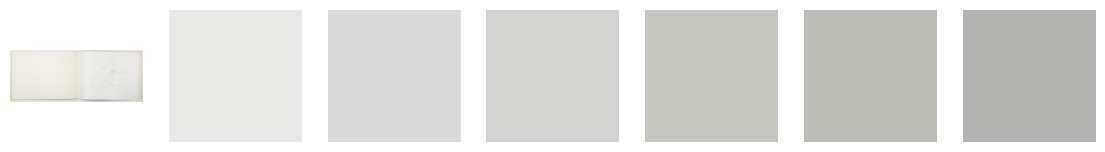

(1200, 1015, 3)


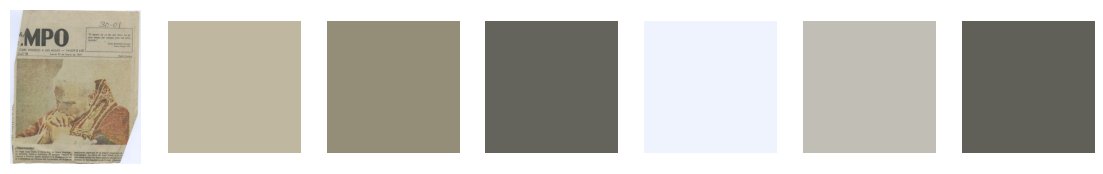

(1200, 850, 3)


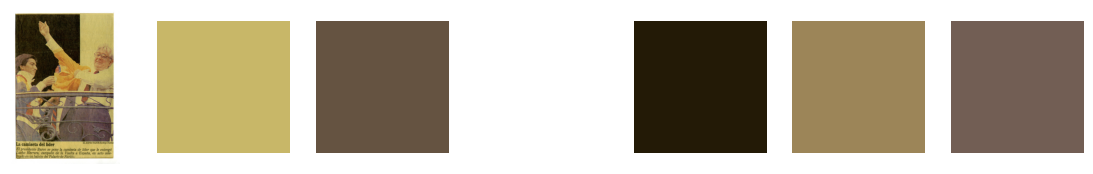

(1200, 745, 3)


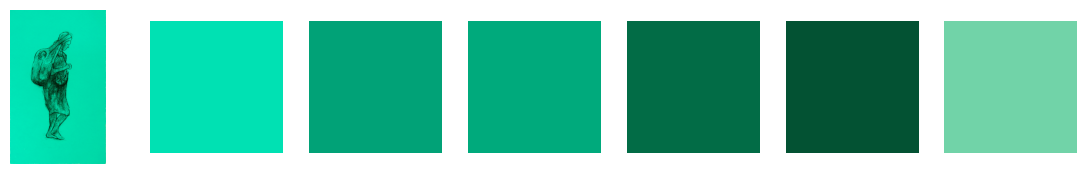

(856, 1200, 3)


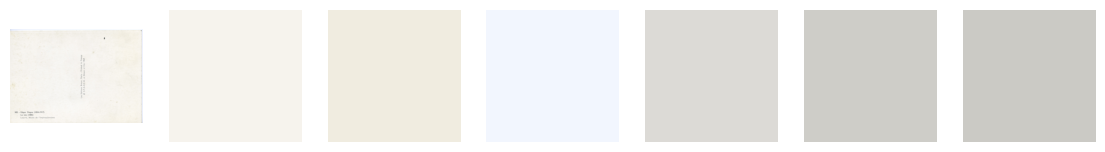

(848, 1200, 3)


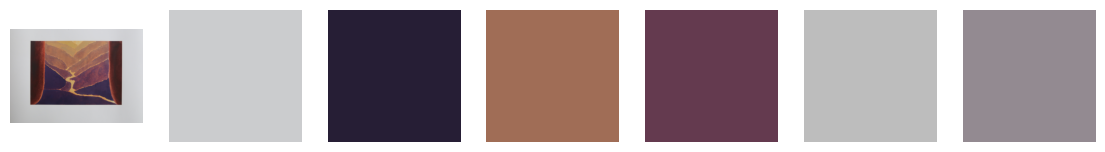

(1080, 1200, 3)


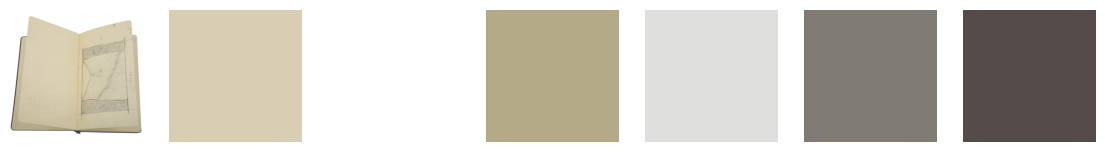

(4000, 3691, 3)


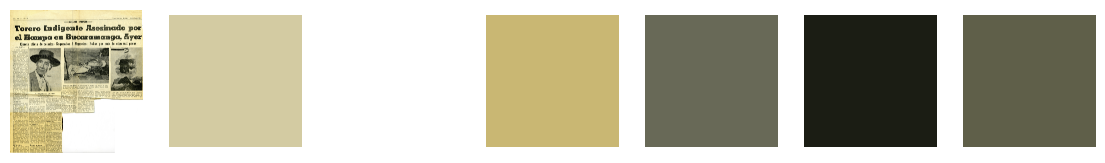

(1200, 863, 3)


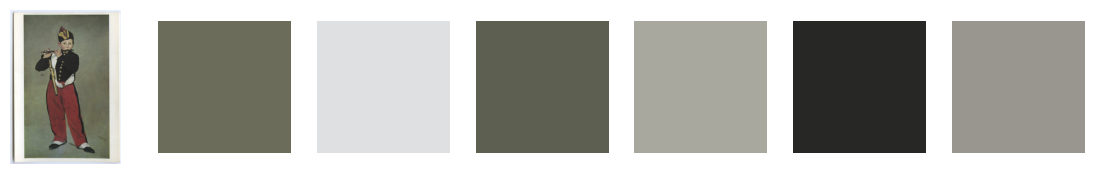

(800, 1200, 3)


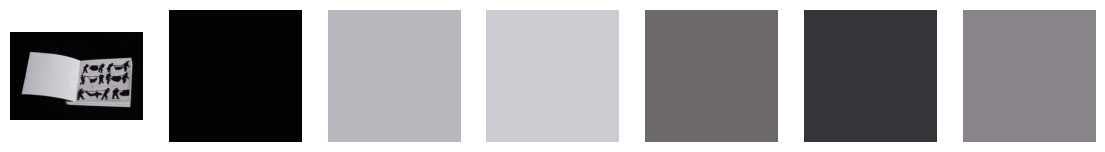

(1200, 800, 3)


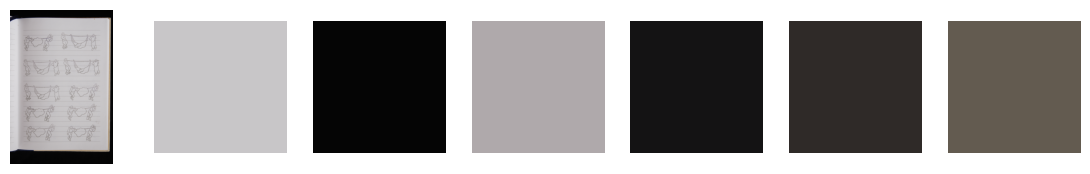

(1134, 778, 3)


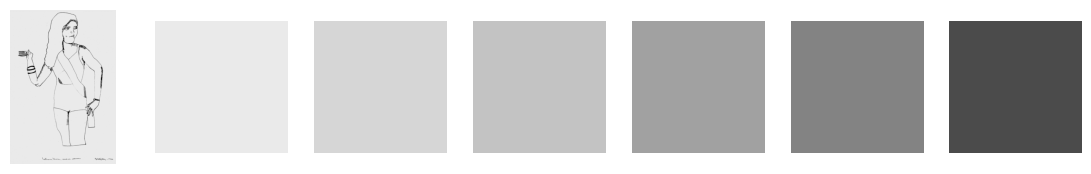

(1800, 1200, 3)


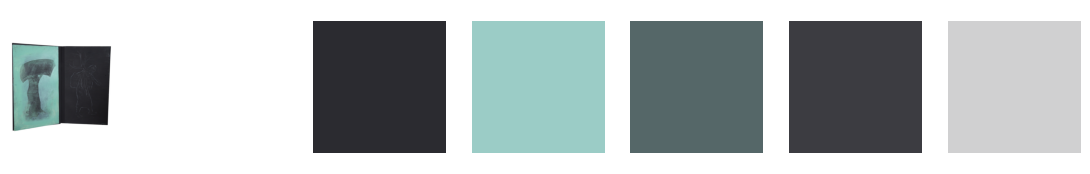

(5662, 2147, 3)


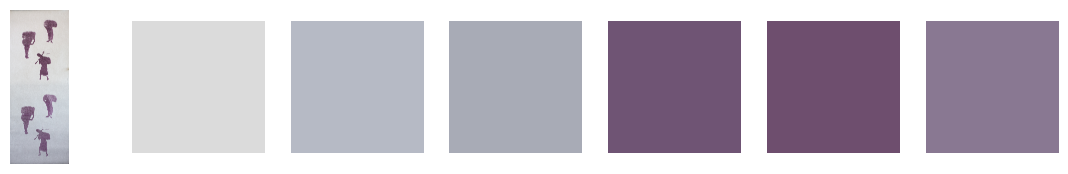

(3471, 3484, 3)


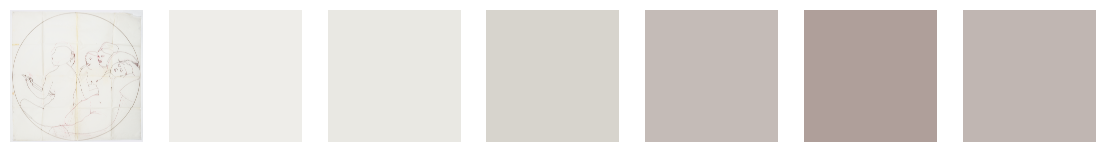

(1200, 1084, 3)


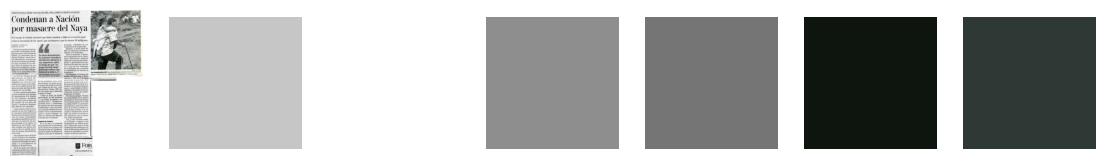

(799, 1200, 3)


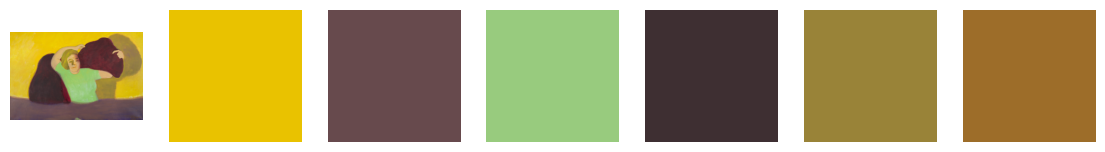

(1572, 4000, 3)


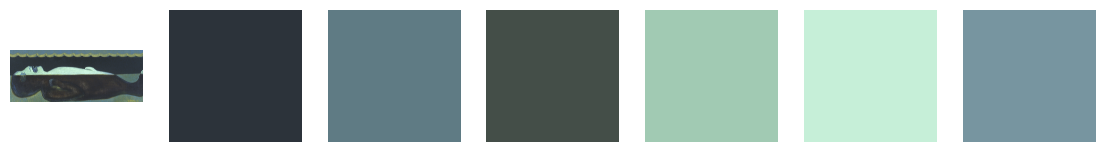

(705, 516, 3)


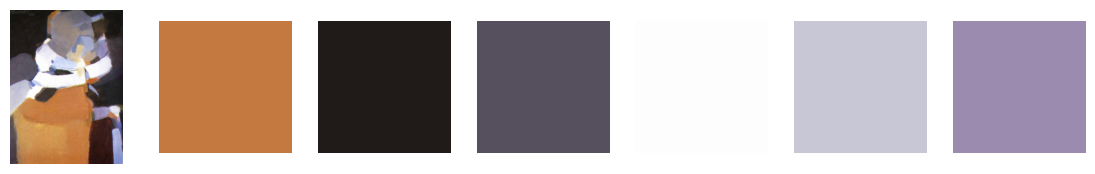

(992, 1134, 3)


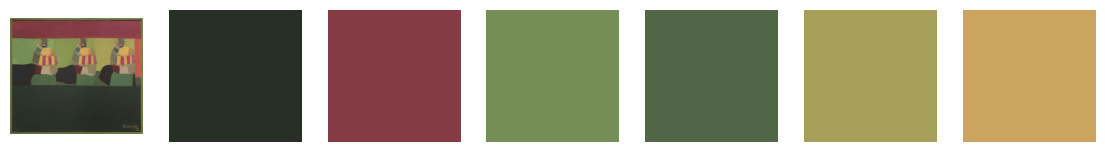

(1200, 1200, 3)


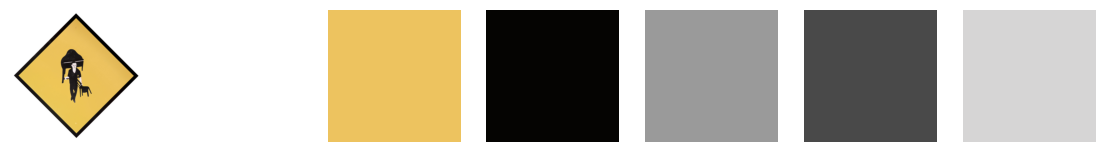

(2813, 3814, 3)


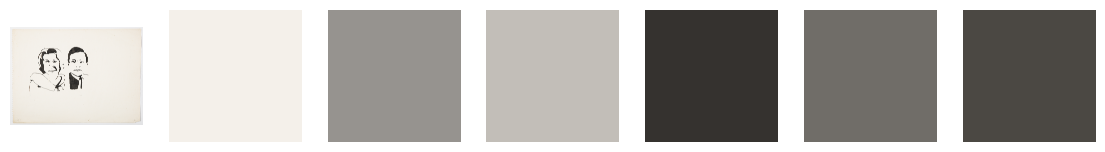

(3756, 2599, 3)


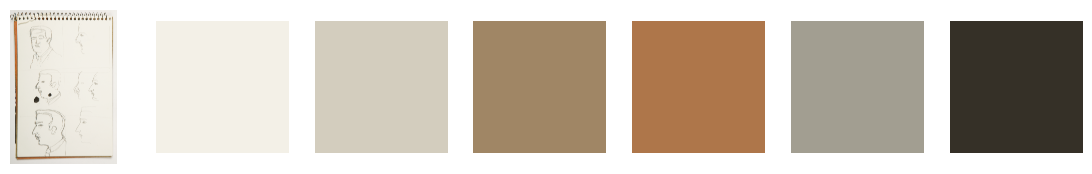

(841, 1200, 3)


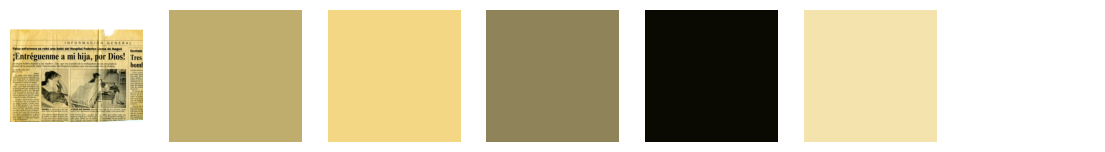

(6586, 4548, 3)


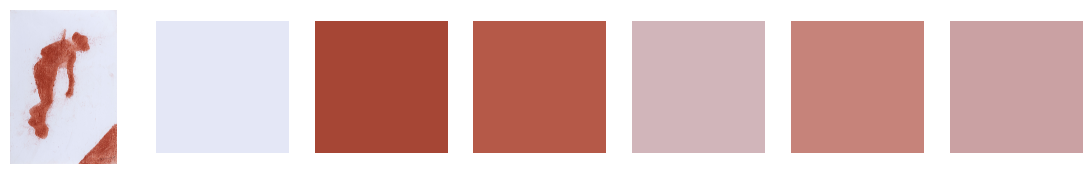

(785, 661, 3)


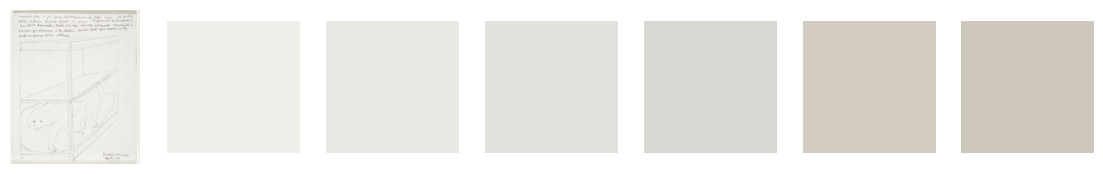

(1654, 2244, 3)


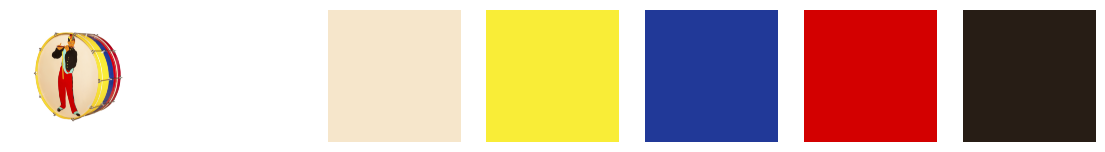

(843, 1200, 3)


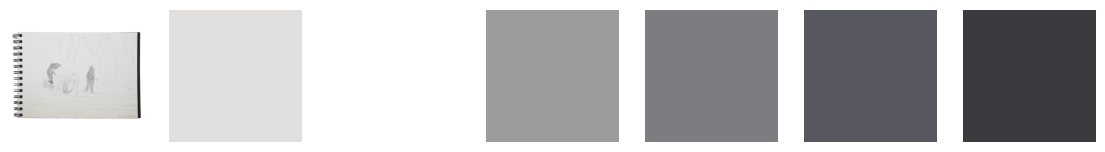

(984, 1200, 3)


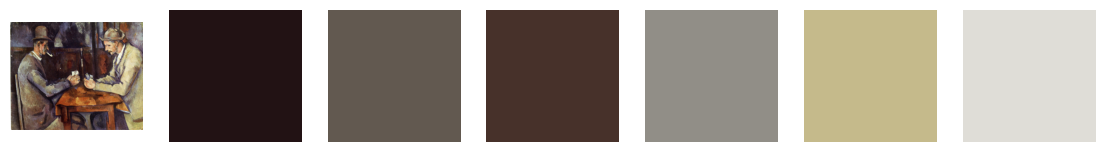

(869, 1200, 3)


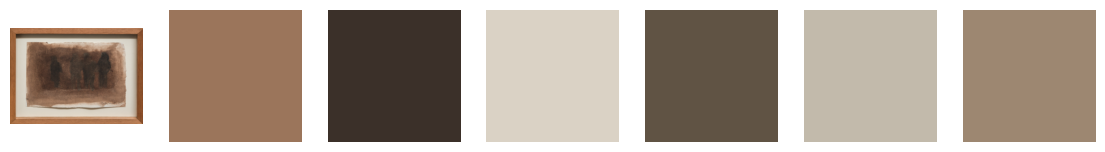

(1200, 767, 3)


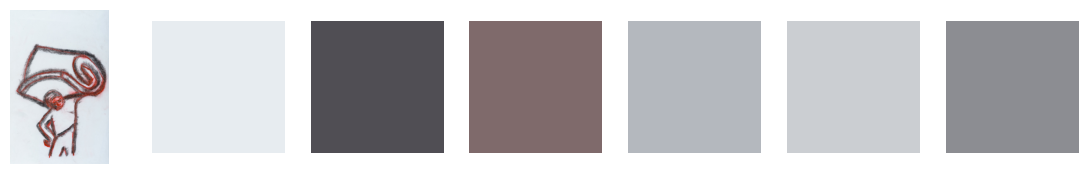

(1200, 874, 3)


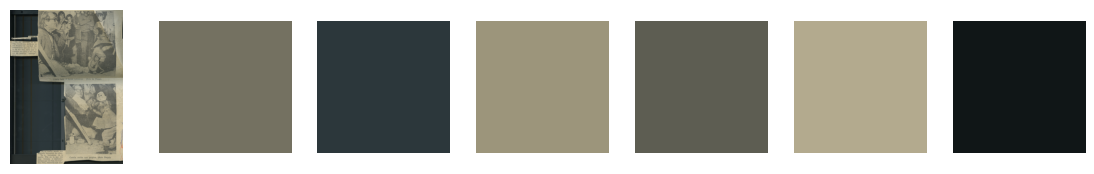

(1200, 789, 3)


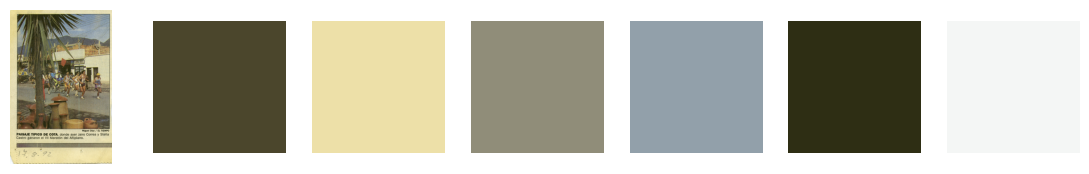

(4000, 2384, 3)


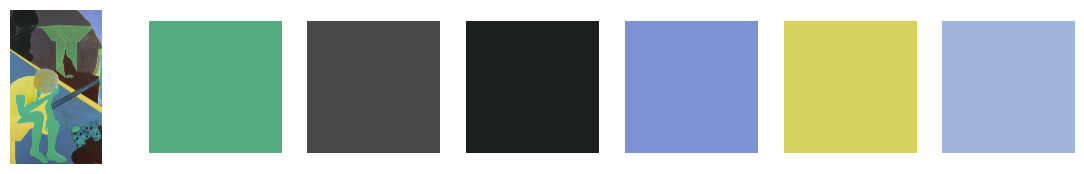

(1155, 765, 3)


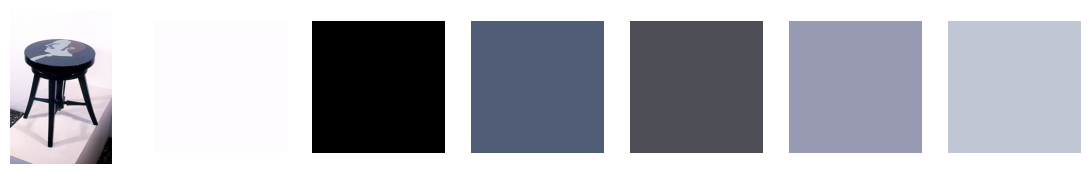

(593, 398, 3)


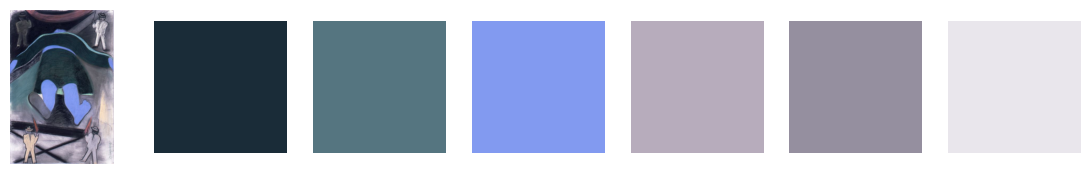

(925, 1200, 3)


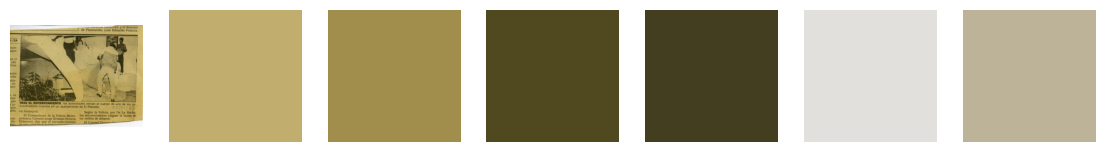

(992, 1200, 3)


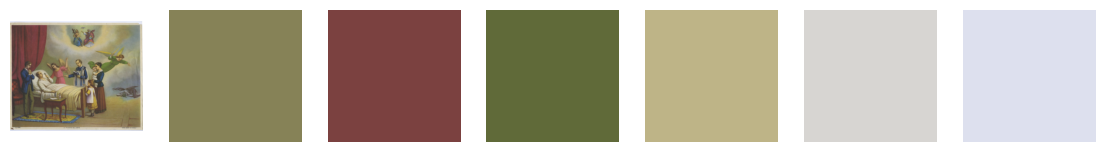

(932, 2870, 3)


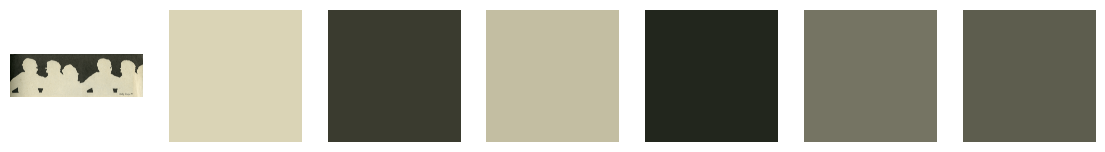

(1142, 829, 3)


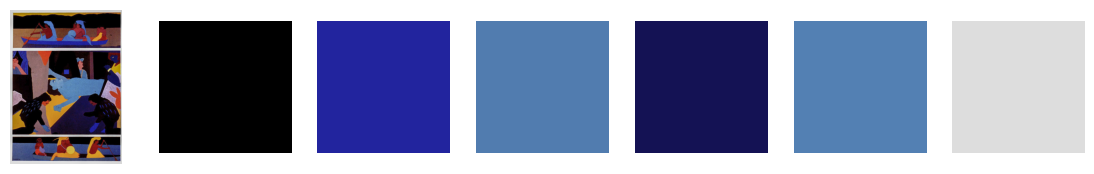

(772, 1200, 3)


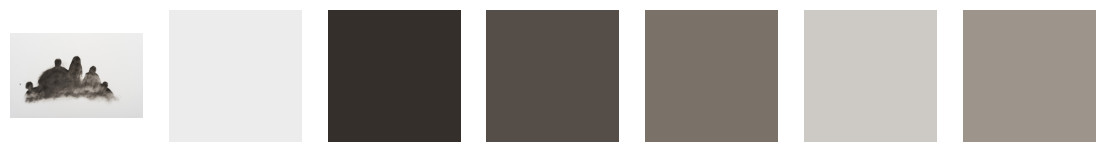

(1200, 1200, 3)


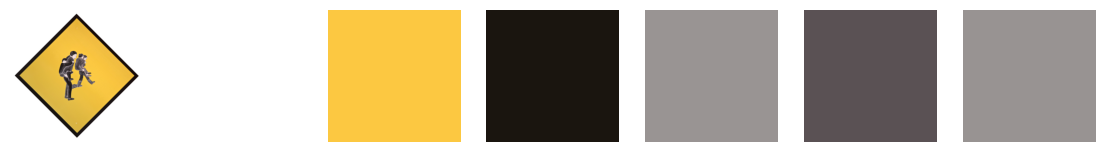

(1200, 812, 3)


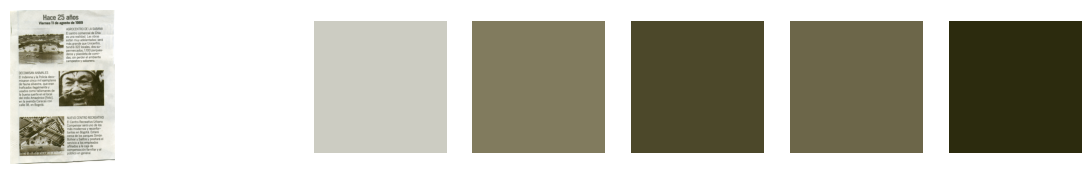

In [14]:
import ast
for i, image in enumerate(imgs):
    print(image.shape)
    if image is not None:
        # img_palette = ast.literal_eval(palette_img[i])
        # img_palette = cv2.cvtColor(np.expand_dims(palette_img[i], axis=0).astype(np.uint8), cv2.COLOR_HSV2RGB)
        show_palette(palette_img[i], img=image)